In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

In [5]:
directory_path = "./histo_data/"

csv_file_names = [
    '1000_JENDL',           # 'XS (b)',            'Ea (eV)'
    '100_Mohr',             # 'XS (b)',            'Ea (eV)'
    '5_Walton_1957',        # 'XS (b)',            'Ea (eV)'

    '4_Febbraro_2020',      # 'XS (b)', 'dXS (b)', 'Ea (eV)'
    '1_Drotleff_1993',      # 'XS (b)', 'dXS (b)', 'Ea (eV)'
    '3_Kellogg_1989',       # 'XS (b)', 'dXS (b)', 'Ea (eV)'
    '8_Davids_1968',        # 'XS (b)', 'dXS (b)', 'Ea (eV)'
    '11_Gao_2022',          # 'XS (b)', 'dXS (b)', 'Ea (eV)'

    '7_Sekharan_1967',      # 'XS (b)', 'dXS (b)', 'Ea (eV)', 'dEa (eV)'
    '2_Bair_1973',          # 'XS (b)', 'dXS (b)', 'Ea (eV)', 'dEa (eV)'
    '10_Prusachenko_2022',  # 'XS (b)', 'dXS (b)', 'Ea (eV)', 'dEa (eV)'
    '6_Brandenburg_2023'    # 'XS (b)', 'dXS (b)', 'Ea (eV)', 'dEa (eV)'
]

csv_file_names_no_all_err = [
    '1000_JENDL',
    '100_Mohr',  
    '5_Walton_1957'
]

csv_file_names_no_E_err = [
    '4_Febbraro_2020',
    '1_Drotleff_1993',
    '3_Kellogg_1989',
    '8_Davids_1968',
    '11_Gao_2022'
]

csv_file_names_all_err = [
    '7_Sekharan_1967',
    '2_Bair_1973',
    '10_Prusachenko_2022',
    '6_Brandenburg_2023'
]

# Создаём словарь датафреймов (ключ — имя файла)
dfs = {}
for csv_file in csv_file_names:
    key = csv_file  # Пример доступа: dfs['1000_JENDL'], dfs['100_Mohr'] и т.д.
    dfs[key] = pd.read_csv(directory_path + csv_file + ".csv")   
    print(dfs[key].head())

   XS_Ea_sum  dXS_Ea   Ea_mean
0        0.0     0.0  301000.0
1        0.0     0.0  303000.0
2        0.0     0.0  305000.0
3        0.0     0.0  307000.0
4        0.0     0.0  309000.0
   XS_Ea_sum  dXS_Ea   Ea_mean
0        0.0     0.0  301000.0
1        0.0     0.0  303000.0
2        0.0     0.0  305000.0
3        0.0     0.0  307000.0
4        0.0     0.0  309000.0
   XS_Ea_sum  dXS_Ea   Ea_mean
0        0.0     0.0  301000.0
1        0.0     0.0  303000.0
2        0.0     0.0  305000.0
3        0.0     0.0  307000.0
4        0.0     0.0  309000.0
   XS_Ea_sum  dXS_Ea   Ea_mean
0        0.0     0.0  301000.0
1        0.0     0.0  303000.0
2        0.0     0.0  305000.0
3        0.0     0.0  307000.0
4        0.0     0.0  309000.0
   XS_Ea_sum  dXS_Ea   Ea_mean
0        0.0     0.0  301000.0
1        0.0     0.0  303000.0
2        0.0     0.0  305000.0
3        0.0     0.0  307000.0
4        0.0     0.0  309000.0
   XS_Ea_sum  dXS_Ea   Ea_mean
0        0.0     0.0  301000.0
1       

Сначала надо подравнять положение пиков по энергии

Потом надо(?) подтянуть амплитуды, чтобы избавиться от систематической ошибки шкалы

# Уже можно объединять данные 

In [7]:
E_min, E_max, delta_E_desired = 300_000, 8_010_000, 2_000   # eV 
num_bins = int(np.ceil((E_max - E_min) / delta_E_desired)) or 1 

num_bins = int(np.ceil((E_max - E_min) / delta_E_desired)) or 1 
bin_edges = np.linspace(E_min, E_max, num_bins + 1) 
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 
delta_E = np.diff(bin_edges) 

combined_sigma = np.zeros(num_bins)
combined_d_sigma = np.zeros(num_bins)

# Объединение по бинам
for bin_idx in range(num_bins):
    sigmas = []
    d_sigmas = []
    for df in dfs.values():
        row = df.iloc[bin_idx]  # Предполагаем одинаковое число строк/бинов
        sigma = row['XS_Ea_sum']    # XS_Ea_sum  dXS_Ea   Ea_mean
        d_sigma = row['dXS_Ea']
        sigmas.append(sigma)
        d_sigmas.append(d_sigma)
    
    sigmas = np.array(sigmas)
    d_sigmas = np.array(d_sigmas)
    mask_positive_err = d_sigmas > 0
    
    if np.any(mask_positive_err):
        weights = 1 / d_sigmas[mask_positive_err]**2
        combined_sigma[bin_idx] = np.sum(sigmas[mask_positive_err] * weights) / np.sum(weights)
        combined_d_sigma[bin_idx] = 1 / np.sqrt(np.sum(weights))
    else:
        # Если все ошибки 0, простое среднее
        combined_sigma[bin_idx] = np.mean(sigmas)
        combined_d_sigma[bin_idx] = 0

# Создаём объединённый DataFrame
combined_df = pd.DataFrame({
    'bin_center': bin_centers,
    'sigma': combined_sigma,
    'd_sigma': combined_d_sigma
})

# Сохраняем в файл
combined_df.to_csv('./histo_data/!combined_histogram.csv', index=False)

print("Объединённая гистограмма сохранена в 'combined_histogram.csv'")
print(combined_df.head())  # Для проверки

Объединённая гистограмма сохранена в 'combined_histogram.csv'
   bin_center  sigma  d_sigma
0    301000.0    0.0      0.0
1    303000.0    0.0      0.0
2    305000.0    0.0      0.0
3    307000.0    0.0      0.0
4    309000.0    0.0      0.0


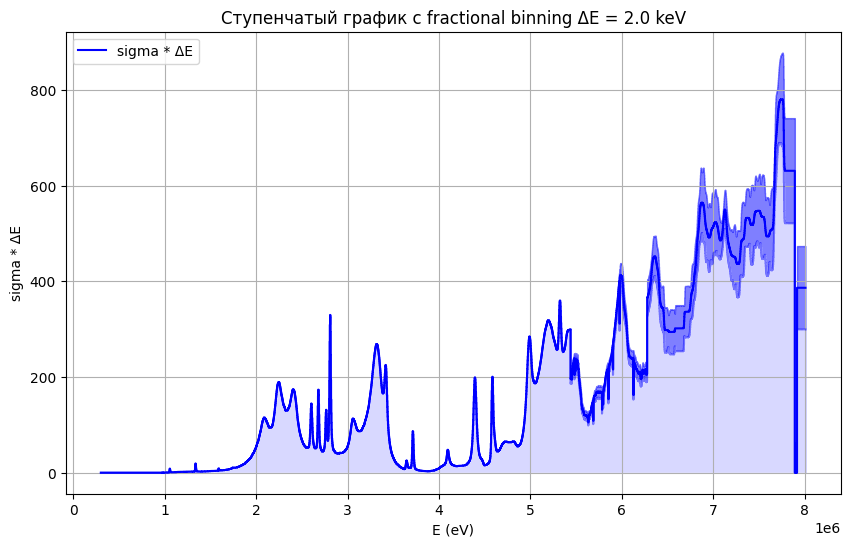

In [ ]:
y           = combined_df['sigma'     ]
err_y       = combined_df['d_sigma'   ]
bin_centers = combined_df['bin_center']

# График 
plt.figure(figsize=(10, 6)) 

# plt.step(bin_edges, np.concatenate([y[0:1] + err_y[0:1], y + err_y]),        where='pre', color='b', alpha=0.5)
plt.fill_between(bin_edges, np.concatenate([y[0:1] + err_y[0:1], y + err_y]), step="pre", color='b', alpha=0.5)
plt.step(bin_edges, np.concatenate([y[0:1], y]),                             where='pre', color='b', label='sigma * ΔE') 
plt.fill_between(bin_edges, np.concatenate([y[0:1] - err_y[0:1], y - err_y]), step="pre", color='w', alpha=0.7)
plt.step(bin_edges, np.concatenate([y[0:1] - err_y[0:1], y - err_y]),        where='pre', color='b', alpha=0.5) 
# plt.errorbar(bin_centers[mask_nonzero], y[mask_nonzero], xerr=delta_E[mask_nonzero]/2, yerr=err_y[mask_nonzero], fmt='none', ecolor='r', capsize=3, label='Errors') 
plt.xlabel('E (eV)') 
plt.ylabel('sigma * ΔE') 
plt.title(f'Ступенчатый график с fractional binning ΔE = {delta_E_desired/1e3} keV') 
plt.legend() 
plt.grid(True) 
plt.savefig('./histo_plot/!combined_histogram.png') 
plt.show()